In [ ]:
import pandas as pd

df = pd.read_csv('../../data/csvs/df_all_smiles.csv')

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen
import pandas as pd
from drugex.training.scorers.smiles import SmilesChecker
import pandas as pd
# Создаем калькулятор с нужным дескриптором
from mordred import Calculator, descriptors

calc = Calculator(descriptors, ignore_3D=True)

allowed_atoms = {'C', 'H', 'O', 'N', 'P', 'S'}

# SMARTS-шаблоны для фенола и аминов
phenol_pattern = Chem.MolFromSmarts('c1ccc(cc1)O')  # Фенольная группа
amine_pattern = Chem.MolFromSmarts('[NX3;H2,H1;!$(NC=O)]')  # Алифатические амины (но не амиды)

def is_valid_molecule(smiles):
    """
    Проверяет молекулу на соответствие критериям:
    - Нейтральность, отсутствие радикалов
    - Масса <= 1000
    - Только разрешённые атомы (C, H, O, N, P, S)
    - logP > 1
    - Наличие фенольной ИЛИ аминной группы
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False

    # 1. Проверка нейтральности и отсутствия радикалов
    if Chem.GetFormalCharge(mol) != 0:
        return False
    if any(atom.GetNumRadicalElectrons() != 0 for atom in mol.GetAtoms()):
        return False

    # 2. Молекулярная масса ≤ 1000
    if Descriptors.MolWt(mol) > 1000:
        return False

    # 3. Только разрешённые атомы
    atoms = {atom.GetSymbol() for atom in mol.GetAtoms()}
    if not atoms.issubset(allowed_atoms):
        return False

    # 4. logP > 1 (растворимость в гексане)
    if Crippen.MolLogP(mol) <= 1:
        return False

    if '+' in smiles:
        return False
    # 5. Наличие фенольной ИЛИ аминной группы
    has_phenol = mol.HasSubstructMatch(phenol_pattern)
    has_amine = mol.HasSubstructMatch(amine_pattern)
    if not (has_phenol or has_amine):
        return False

    if SmilesChecker.checkSmiles([smiles])['Valid'].to_list()[0] != 1.0:
        return False
    
    return True


# Функция для расчета AATSC0d
def compute_aatsc0d(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        result = calc(mol)
        return result['AATSC0d']
    except:
        return None

# Пример использования с DataFrame
# df = pd.read_csv("your_data.csv")  # Ваш DataFrame с колонкой 'SMILES'
df_filtered = df[df['SMILES'].apply(is_valid_molecule)].copy()

# Добавляем информацию о наличии фенольных/аминных групп
df_filtered['HasPhenol'] = df_filtered['SMILES'].apply(
    lambda smi: Chem.MolFromSmiles(smi).HasSubstructMatch(phenol_pattern))
df_filtered['HasAmine'] = df_filtered['SMILES'].apply(
    lambda smi: Chem.MolFromSmiles(smi).HasSubstructMatch(amine_pattern))

df_filtered['AATSC0d'] = df_filtered['SMILES'].apply(compute_aatsc0d)

print(f"Прошло фильтрацию: {len(df_filtered)} молекул из {len(df)}")
print("Распределение:")
print(f"- С фенольной группой: {df_filtered['HasPhenol'].sum()}")
print(f"- С аминной группой: {df_filtered['HasAmine'].sum()}")
print(f"- С обоими группами: {((df_filtered['HasPhenol']) & (df_filtered['HasAmine'])).sum()}")

Прошло фильтрацию: 11584 молекул из 16718
Распределение:
- С фенольной группой: 9338
- С аминной группой: 3849
- С обоими группами: 1603


In [6]:
df_filtered['O_count'] = df_filtered['SMILES'].str.count('O')

In [ ]:
df_filtered = df_filtered.sort_values(by='AATSC0d', ascending=False)

In [ ]:
result_df = df_filtered.iloc[:1000]
result_df = result_df[result_df.O_count > 12]

In [50]:
result_df

,SMILES,HasPhenol,HasAmine,O_count,preds
13613,COc1cc(C=C2C(=O)N(c3ccc(O)cc3C(=O)O)C(c3ccc(O)...,True,False,12,259.725686
5317,COc1ccc(C(=O)OCC2Oc3ccc(-c4oc5cc(O)cc(O)c5c(=O...,True,False,11,234.626136
11435,CC(=O)OC1C(C)OC(Oc2c(-c3ccc(O)cc3)oc3c(CC=C(C)...,True,False,10,205.913016
3079,COc1cc(C2Oc3cc([C@H]4Oc5cc(O)cc(O)c5C(=O)[C@@H...,True,False,13,195.538278
3071,COc1cc(C2Oc3cc([C@H]4Oc5cc(O)cc(O)c5C(=O)[C@@H...,True,False,14,179.412023
...,...,...,...,...,...
5134,O=C(OC[C@H]1O[C@@H](OC(=O)c2cc(O)c(O)c(O)c2)[C...,True,False,26,70.277586
3085,COc1ccc(C(=O)C(COC(=O)c2ccc(O)cc2)Oc2c(OC)cc(/...,True,False,13,70.233271
13659,O=C1CC(c2ccc(O)c(-c3c(O)cc(O)c4c3OC(c3ccc(O)cc...,True,False,10,69.898277
4762,COC(=O)CSCc1c(O)c(CSCC(=O)OC)c2c(c1O)C[C@@H](O...,True,False,15,69.352633


In [51]:
result_smiles = result_df['SMILES'].to_list()

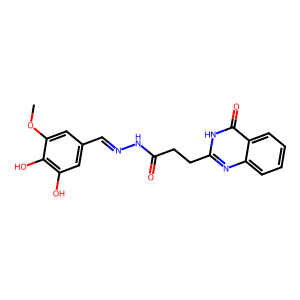

In [22]:
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

mol = Chem.MolFromSmiles(result_smiles[1])
drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:', '')
SVG(svg)


In [ ]:
from drugex.training.scorers.properties import Property, Uniqueness, AtomCounter
from drugex.training.scorers.modifiers import ClippedScore
from drugex.training.environment import DrugExEnvironment
from drugex.training.rewards import WeightedSum
from drugex.training.scorers.qsprpred import QSPRPredScorer
from drugex.training.scorers.properties import Uniqueness
from qsprpred.models.scikit_learn import SklearnModel


from rdkit import Chem


# 🔬 1. Модель для предсказания времени индукционного окисления (например, RandomForestRegressor)
scorer_tio = QSPRPredScorer(
    model = SklearnModel(
        name="A2AR_ForestRegressor_hack_data_extended_with_submits",
        base_dir='data/models/qsar/',
    )
)

scorer_tio.setModifier(ClippedScore(lower_x=200, upper_x=600))  # время в минутах
scorers = [scorer_tio]
uniq_scorer = Uniqueness(modifier=ClippedScore(lower_x=0.0, upper_x=0.5))
# scorers.append(uniq_scorer)
oxygen_scorer = AtomCounter('O', modifier=ClippedScore(lower_x=17, upper_x=40))
# scorers.append(oxygen_scorer)

sascore = Property("SA", modifier=ClippedScore(lower_x=5, upper_x=3))
scorers.append(sascore)
thresholds.append(4)

qed = Property("QED", modifier=ClippedScore(lower_x=0.4, upper_x=1.0))
scorers.append(qed)
thresholds.append(0.8)


logp = Property("logP", modifier=ClippedScore(lower_x=1.0, upper_x=6.0))
scorers.append(logp)
thresholds.append(3)

mw = Property("MW", modifier=ClippedScore(lower_x=100, upper_x=950))
scorers.append(mw)
thresholds.append(500)

environment = DrugExEnvironment(
    scorers=scorers,
    reward_scheme=WeightedSum()  # можно заменить на ParetoCrowdingDistance, если нужно
)


In [53]:
import os
from drugex.data.datasets import GraphFragDataSet
from drugex.molecules.converters.dummy_molecules import dummyMolsFromFragments
from drugex.data.fragments import FragmentCorpusEncoder, GraphFragmentEncoder
from drugex.data.corpus.vocabulary import VocGraph
from drugex.molecules.converters.fragmenters import Fragmenter

fragmenter = dummyMolsFromFragments()
splitter = None

encoder = FragmentCorpusEncoder(
    fragmenter=Fragmenter(4, 4, 'brics'), 
    encoder=GraphFragmentEncoder(
        VocGraph(n_frags=4) 
    ),
    pairs_splitter=splitter, 
    n_proc=10,
    chunk_size=1
)

graph_input_folder = "data/encoded/graph"
if not os.path.exists(graph_input_folder):
    os.makedirs(graph_input_folder)
    
dataset = GraphFragDataSet(f"{graph_input_folder}/scaffolds.tsv", rewrite=True)

In [ ]:
encoder.apply(list(result_smiles), encodingCollectors=[dataset])

Creating fragment-molecule pairs (batch processing):   0%|          | 0/5 [00:00<?, ?it/s]

Encoding fragment-molecule pairs. (batch processing):   0%|          | 0/26 [00:00<?, ?it/s]

The following exception occured while encoding fragment O=C1c2c(O)cc(O)cc2OC[C@H]1O for molecule COc1cc(C2Oc3cc([C@H]4Oc5cc(O)cc(O)c5C(=O)[C@@H]4O)ccc3OC2COC(=O)c2ccc3c(c2)OCO3)ccc1O: 
The following exception occured while encoding fragment O=C1c2c(O)cc(O)cc2OC[C@H]1O.c1ccc2c(c1)OCO2 for molecule COc1cc(C2Oc3cc([C@H]4Oc5cc(O)cc(O)c5C(=O)[C@@H]4O)ccc3OC2COC(=O)c2ccc3c(c2)OCO3)ccc1O: 
The following exception occured while encoding fragment c1ccc2c(c1)OCO2 for molecule COc1cc(C2Oc3cc([C@H]4Oc5cc(O)cc(O)c5C(=O)[C@@H]4O)ccc3OC2COC(=O)c2ccc3c(c2)OCO3)ccc1O: 
Failed to convert item None to the new representation in <drugex.data.fragments.FragmentPairsEncodedSupplier object at 0x7f5593b5ee30>
	 Cause: FragmentEncodingException('Failed to encode fragment O=C1c2c(O)cc(O)cc2OC[C@H]1O from molecule: COc1cc(C2Oc3cc([C@H]4Oc5cc(O)cc(O)c5C(=O)[C@@H]4O)ccc3OC2COC(=O)c2ccc3c(c2)OCO3)ccc1O')
The following exception occured while encoding fragment c1ccc2c(c1)OCCO2 for molecule COc1cc(C2Oc3cc([C@H]4Oc5cc(

In [ ]:
GPUS = [0]

In [ ]:
from drugex.training.explorers import FragGraphExplorer
from drugex.training.generators import GraphTransformer
from drugex.data.corpus.vocabulary import VocGraph

vocabulary = VocGraph.fromFile('../../models/pretrained_graph/Papyrus05.5_graph_trans_PT.vocab')
agent = GraphTransformer(voc_trg=vocabulary, use_gpus=GPUS)
agent.loadStatesFromFile('../../models/pretrained_graph/Papyrus05.5_graph_trans_PT.pkg')
prior = GraphTransformer(voc_trg=vocabulary, use_gpus=GPUS)
prior.loadStatesFromFile('../../models/pretrained_graph/Papyrus05.5_graph_trans_PT.pkg')

explorer = FragGraphExplorer(agent=agent, env=environment, mutate=prior, epsilon=0.1, use_gpus=GPUS)

In [94]:
from drugex.data.datasets import GraphFragDataSet

data_path = f'{graph_input_folder}/scaffolds.tsv'
train_loader = GraphFragDataSet(data_path).asDataLoader(batch_size=1024, n_samples=100)
test_loader = GraphFragDataSet(data_path).asDataLoader(batch_size=1024, n_samples=100, n_samples_ratio=0.2)

In [ ]:
from drugex.training.monitors import FileMonitor

monitor = FileMonitor("../../models/finetuned_graph_with_o_new/scaffolds.pkg", save_smiles=True) 
explorer.fit(train_loader, test_loader, monitor=monitor, epochs=5)

Fitting graph explorer:   0%|          | 0/5 [00:00<?, ?it/s]

Iterating over training batches:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting graph explorer:  20%|██        | 1/5 [00:19<01:18, 19.71s/it]

Iterating over training batches:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting graph explorer:  40%|████      | 2/5 [00:39<00:58, 19.50s/it]

Iterating over training batches:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting graph explorer:  60%|██████    | 3/5 [00:58<00:38, 19.25s/it]

Iterating over training batches:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting graph explorer:  80%|████████  | 4/5 [01:17<00:19, 19.28s/it]

Iterating over training batches:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting graph explorer: 100%|██████████| 5/5 [01:36<00:00, 19.27s/it]


We look that all created molecules include either a pyrazine or a pyrazine and a thiophene.

In [ ]:
reinforced = GraphTransformer(voc_trg=VocGraph(), use_gpus=GPUS)
reinforced.loadStatesFromFile('../../models/finetuned_graph_with_o_new/scaffolds.pkg')
denovo_new = reinforced.generate(input_frags=result_smiles, num_samples=400, evaluator=environment)

Initialized empty dataset. The data set file does not exist (yet): /tmp/tmphwgocpd9. You can add data by calling this instance with the appropriate parameters.


Creating fragment-molecule pairs (batch processing):   0%|          | 0/1 [00:00<?, ?it/s]

Encoding fragment-molecule pairs. (batch processing):   0%|          | 0/1 [00:00<?, ?it/s]

The following exception occured while encoding fragment COc1cc(C2Oc3cc([C@H]4Oc5cc(O)cc(O)c5C(=O)[C@@H]4O)ccc3OC2COC(=O)c2ccc3c(c2)OCO3)ccc1O for molecule CCCOc1cc(C2Oc3cc([C@H]4Oc5cc(O)cc(O)c5C(=O)[C@@H]4O)ccc3OC2COC(=O)c2ccc3c(c2)OCO3)ccc1O: 
Failed to convert item None to the new representation in <drugex.data.fragments.FragmentPairsEncodedSupplier object at 0x7f55966578b0>
	 Cause: FragmentEncodingException('Failed to encode fragment COc1cc(C2Oc3cc([C@H]4Oc5cc(O)cc(O)c5C(=O)[C@@H]4O)ccc3OC2COC(=O)c2ccc3c(c2)OCO3)ccc1O from molecule: CCCOc1cc(C2Oc3cc([C@H]4Oc5cc(O)cc(O)c5C(=O)[C@@H]4O)ccc3OC2COC(=O)c2ccc3c(c2)OCO3)ccc1O')
The following exception occured while encoding fragment COc1cc(C2Oc3cc([C@H]4Oc5cc(OC(=O)c6ccc7c(c6)OC(C)(C)O7)cc(O)c5C(=O)[C@@H]4O)ccc3OC2CO)ccc1O for molecule CCCOc1cc(C2Oc3cc([C@H]4Oc5cc(OC(=O)c6ccc7c(c6)OC(C)(C)O7)cc(O)c5C(=O)[C@@H]4O)ccc3OC2CO)ccc1O: 
Failed to convert item None to the new representation in <drugex.data.fragments.FragmentPairsEncodedSupplier o

Generating molecules:   0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
denovo_filtered_new = denovo_new[denovo_new['SMILES'].apply(is_valid_molecule)].drop_duplicates(subset='SMILES').copy()

In [106]:
denovo_filtered_new['O_count'] = denovo_filtered_new['SMILES'].str.count('O')

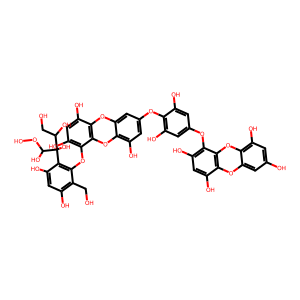

In [90]:
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

mol = Chem.MolFromSmiles(denovo_filtered_new.sort_values(by='O_count').SMILES.tolist()[-1])
drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:', '')
SVG(svg)


In [ ]:
submission_list = denovo_filtered_new.sort_values(by='O_count')['SMILES'].to_list()[-10:]
pd.DataFrame({'SMILES': submission_list}).to_csv('submission.csv', index=False, encoding='utf-8')